In [4]:
import os

import numpy as np
import geopandas as gpd
from shapely.geometry.point import Point
import xarray
import wavespectra
import contextily as cx

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import windrose
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar

## Set file paths

In [ ]:
fp_geo = r"C:\Users\z3541792\OneDrive - UNSW\Research\ShoreShop2.0\data\curlcurl\shoreline\Image\CurlCurl"
fp_sl = os.path.join(fp_geo, 'CurlCurl_reference_shoreline.geojson')
fp_tran = os.path.join(fp_geo, 'CoastSat_transect_curlcurl.geojson')

fp_wave = r"C:\Users\z3541792\OneDrive - UNSW\General - ARC FT220100009 - Splinter Shoreline Modelling\RegionalWaveModelling\wave_downscaling\raw_data\ERA5_spectral_points\Spec_ERA5_sydney.nc"

## Read data

In [3]:
ds = xr.open_dataset(fp_wave)
ds = ds.rename({'frequency' : 'freq', 'direction' : 'dir'})
ds['efth'] = ds['efth'] * np.pi /180
ds['dir'] = ds['dir'] - 180
ds['dir'] = np.where(ds['dir']<0, ds['dir']+360, ds['dir'])
lon_wave = ds.longitude.values.item()
lat_wave = ds.latitude.values.item()
Hs = ds.efth.spec.hs().values
Tp = ds.efth.spec.tp().values
Dir = ds.efth.spec.dm().values

C:\Users\z3541792\AppData\Local\anaconda3\envs\wave_env\Lib\site-packages\ecmwflibs\__init__.py:81: UserWarning: DLL load failed while importing _ecmwflibs: The specified procedure could not be found.
  warnings.warn(str(e))
C:\Users\z3541792\AppData\Local\anaconda3\envs\wave_env\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
gdf_sl = gpd.read_file(fp_sl).to_crs('EPSG:4326')
minx, miny, maxx, maxy = gdf_sl.geometry.bounds.values[0]
gdf_tran = gpd.read_file(fp_tran).to_crs('EPSG:4326')

buoy_coords = [151.4117, -33.7739]

points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## Plot map

C:\Users\z3541792\AppData\Local\Temp\ipykernel_20104\1901697233.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  main_ax.text(gdf_sl.geometry.centroid[0].xy[0][0]-0.05, gdf_sl.geometry.centroid[0].xy[1][0]+0.01, 'Beach X: Curl Curl',  color='r')
C:\Users\z3541792\AppData\Local\Temp\ipykernel_20104\1901697233.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_tran.interpolate(0).plot(ax=ax, color='y', markersize=100)
C:\Users\z3541792\AppData\Local\anaconda3\envs\wave_env\Lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.start

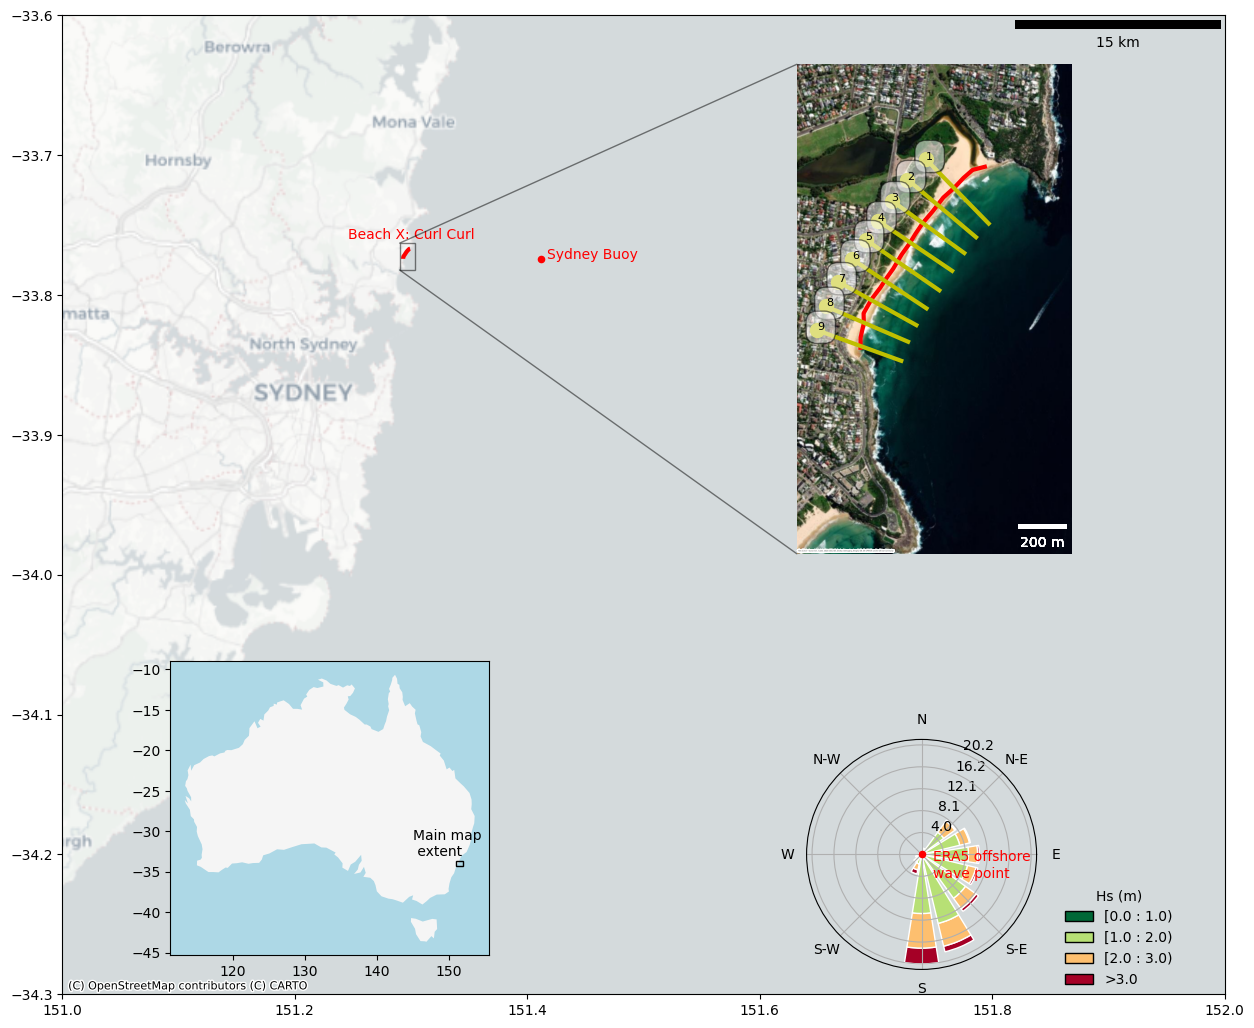

In [6]:
fig, main_ax = plt.subplots(1, 1, figsize=(15, 15))

main_ax.set_xlim(151, 152)
main_ax.set_ylim(-34.3, -33.6)
#gdf_sl.centroid.plot(ax=main_ax, color='r', markersize=100)
gdf_sl.plot(ax=main_ax, color='r', linewidth=3)
main_ax.text(gdf_sl.geometry.centroid[0].xy[0][0]-0.05, gdf_sl.geometry.centroid[0].xy[1][0]+0.01, 'Beach X: Curl Curl',  color='r')
cx.add_basemap(main_ax, crs=gdf_sl.crs, source=cx.providers.CartoDB.Positron)
main_ax.scatter(buoy_coords[0], buoy_coords[1], marker='o', color='r', s=20)
main_ax.text(buoy_coords[0]+0.005, buoy_coords[1], 'Sydney Buoy', color='r')


ax = main_ax.inset_axes([0.6, 0.45, 0.3, 0.5], xlim=(minx-0.003, maxx+0.004), ylim=(miny-0.008, maxy+0.004))

gdf_sl.plot(ax=ax, color='r', linewidth=3)
gdf_tran.plot(ax=ax, color='y', linewidth=3)
gdf_tran.interpolate(0).plot(ax=ax, color='y', markersize=100)
for i, row in gdf_tran.iterrows():
    ax.text(row.geometry.interpolate(0).xy[0][0], row.geometry.interpolate(0).xy[1][0], row['name'][-1], fontsize=8,
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1', alpha=0.5))
    cx.add_basemap(ax, crs=gdf_sl.crs, source=cx.providers.Esri.WorldImagery, attribution_size=1)
    ax.axis('off')
    ax.add_artist(ScaleBar(distance_meters, box_alpha=0, color='white', location='lower right'))

main_ax.indicate_inset_zoom(ax, edgecolor="black")
main_ax.add_artist(ScaleBar(distance_meters, box_alpha=0))
# ax.set_xlim(minx-0.003, maxx+0.004)
# ax.set_ylim(miny-0.008, maxy+0.004)

ax2 = main_ax.inset_axes([0.08, 0.04, 0.3, 0.3])
world[world['name']=='Australia'].plot(ax=ax2, color='whitesmoke')
rect = patches.Rectangle((151, -34.3), 1, 0.7, linewidth=1, edgecolor='k', facecolor='none')
ax2.add_patch(rect)
ax2.set_facecolor('lightblue')
ax2.text(145, -33, 'Main map\n extent')




wrax = inset_axes(
    main_ax,
    width=2.3,  # size in inches
    height=2.3,  # size in inches
    loc="center",  # center bbox at given position
    bbox_to_anchor=(lon_wave, lat_wave),  # position of the axe
    bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
    axes_class=windrose.WindroseAxes,  # specify the class of the axe
)
wrax.patch.set_alpha(0)

wrax.bar(Dir, Hs, normed=True, opening=0.8, bins=[0, 1, 2, 3], 
    cmap=cm.RdYlGn_r, edgecolor='white')
cbar = wrax.legend(loc=(1.1, -0.1), title='Hs (m)')
cbar.get_frame().set_alpha(0)
wrax.scatter(0.5, 0.5, marker='o', color='r', s=20, transform=wrax.transAxes, zorder=100)
wrax.text(0.55, 0.4, 'ERA5 offshore\nwave point', transform=wrax.transAxes, color='r')

fig.savefig('figures/site_map.jpg', dpi=300,  bbox_inches='tight')
#main_ax.text(lon_wave, lat_wave, 'Offshore wave')